In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/My Drive/Images.zip", 'r')
zip_ref.extractall("Ph")
zip_ref.close()

In [ ]:
pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.9 MB/s eta 0:00:00


In [ ]:
pip install timm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.3 MB/s eta 0:00:00


In [ ]:
pip install fastai -q

In [ ]:
pip install efficientnet_pytorch -q

  Preparing metadata (setup.py) ... done


In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision import models, transforms
import random
from tqdm import tqdm
import shutil
from timm import create_model
import fastai
from fastai.vision.all import *
from sklearn.metrics.pairwise import cosine_similarity
from fastai.losses import MSELossFlat
from efficientnet_pytorch import EfficientNet
from fastai.callback.schedule import ParamScheduler
from torch.nn import L1Loss

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 4
BATCH_SIZE = 7

In [ ]:
prompts = pd.read_csv('train.csv', sep = ';')
prompts

,prompt,uuid_img_paths
0,"Futuristic web page cover of software downloads in high definition, color full, 4k, background arrows - variations",0cda87e0-d7f7-409b-a87d-1f336953b40f.png
1,woman,b1978e45-570f-43b1-96dd-7faa61d241db.png
2,back ground gold,05bbacc5-55f2-4804-a5c7-85ece5364d76.png
3,"a giant laying his back on a mountain, a the giant hugging a city",73fd0bfa-db98-44aa-8f4a-9188baa24c6c.png
4,"logo for instagram, hammam, no text, blue and earth colours, palm trees, arabic theme",be313237-dc9c-4634-b973-e53b41a124bd.png
...,...,...
699,"A vampire in a leather cloak with black short hair, red eyes with an outstretched hand, above which a sphere of red liquid hovers, near him are zombies smeared in red, behind the vampire is a castle tower that emits green light, above which is a green crystal, under the crystal stands a man in a robe , 4k",0a65c882-ad1c-493b-8d06-2087c5c24d8b.png
700,"A vampire in a leather cloak with black short hair, red eyes with an outstretched hand, above which a sphere of red liquid hovers, near him are zombies smeared in red, behind the vampire is a castle tower that emits green light, above which is a green crystal, under the crystal stands a man in a robe , 4k",726c4c01-540e-4e96-aaad-f0f56808f474.png
701,"A vampire in a leather cloak with black short hair, red eyes with an outstretched hand, above which a sphere of red liquid hovers, near him are zombies smeared in red, behind the vampire is a castle tower that emits green light, above which is a green crystal, under the crystal stands a man in a robe , 4k",cfe87035-b685-4d25-8889-581a636899ef.png
702,"A vampire in a leather cloak with black short hair, red eyes with an outstretched hand, above which a sphere of red liquid hovers, near him are zombies smeared in red, behind the vampire is a castle tower that emits green light, above which is a green crystal, under the crystal stands a man in a robe , 4k",77779bd0-8905-4d8d-a68d-797fae5455b9.png


Для удобства меняю названия картинок на порядковые номера в датафрейме и в самой папке с картинками

In [ ]:
def rename_images(image_list, image_dir):
    new = []
    image_set = set(image_list)
    for i, image_name in enumerate(image_list):
        old_path = os.path.join(image_dir, image_name)
        new_path = os.path.join(image_dir, f"{str(i).zfill(4)}.png")
        new.append(f"{str(i).zfill(4)}.png")
        os.rename(old_path, new_path)
    prompts['uuid_img_paths'] = new
    for file_name in os.listdir(image_dir):
        if file_name.endswith(".png") and len(file_name[:-4]) > 4:
            file_path = os.path.join(image_dir, file_name)
            os.remove(file_path)

rename_images(prompts['uuid_img_paths'], "Ph/images/")
prompts

,prompt,uuid_img_paths
0,"Futuristic web page cover of software downloads in high definition, color full, 4k, background arrows - variations",0000.png
1,woman,0001.png
2,back ground gold,0002.png
3,"a giant laying his back on a mountain, a the giant hugging a city",0003.png
4,"logo for instagram, hammam, no text, blue and earth colours, palm trees, arabic theme",0004.png
...,...,...
699,"A vampire in a leather cloak with black short hair, red eyes with an outstretched hand, above which a sphere of red liquid hovers, near him are zombies smeared in red, behind the vampire is a castle tower that emits green light, above which is a green crystal, under the crystal stands a man in a robe , 4k",0699.png
700,"A vampire in a leather cloak with black short hair, red eyes with an outstretched hand, above which a sphere of red liquid hovers, near him are zombies smeared in red, behind the vampire is a castle tower that emits green light, above which is a green crystal, under the crystal stands a man in a robe , 4k",0700.png
701,"A vampire in a leather cloak with black short hair, red eyes with an outstretched hand, above which a sphere of red liquid hovers, near him are zombies smeared in red, behind the vampire is a castle tower that emits green light, above which is a green crystal, under the crystal stands a man in a robe , 4k",0701.png
702,"A vampire in a leather cloak with black short hair, red eyes with an outstretched hand, above which a sphere of red liquid hovers, near him are zombies smeared in red, behind the vampire is a castle tower that emits green light, above which is a green crystal, under the crystal stands a man in a robe , 4k",0702.png


In [ ]:
prompts['prompt'] = [i.lower() for i in prompts['prompt']]

Создание эмбеддингов для промптов

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased')

def to_emb(prompts):
  emb = []
  for i in prompts.prompt:
    input = tokenizer.encode(i, add_special_tokens = True)
    input = torch.tensor(input).unsqueeze(0)
    with torch.no_grad():
        output = model(input)
        hidden_states = output.last_hidden_state.squeeze(0)
        sentence_emb = hidden_states[0]
        emb.append(sentence_emb)
  prompts['emb'] = emb
  return prompts

prompts = to_emb(prompts)
prompts

,prompt,uuid_img_paths,emb
0,"futuristic web page cover of software downloads in high definition, color full, 4k, background arrows - variations",0000.png,"[tensor(0.3731), tensor(0.0611), tensor(-0.0936), tensor(-0.4815), tensor(-0.3446), tensor(-0.1989), tensor(0.0625), tensor(0.1432), tensor(-0.0226), tensor(-0.9568), tensor(-0.5948), tensor(0.2907), tensor(-0.1097), tensor(-0.0146), tensor(-0.6607), tensor(0.0740), tensor(0.2572), tensor(-0.0441), tensor(0.0203), tensor(-0.3472), tensor(0.1278), tensor(-0.1730), tensor(0.7225), tensor(-0.3112), tensor(0.1186), tensor(-0.1840), tensor(0.1736), tensor(-0.0854), tensor(-0.0093), tensor(0.3382), tensor(-0.2537), tensor(0.5823), tensor(0.1184), tensor(-0.0463), tensor(-0.3273), tensor(0.1272),..."
1,woman,0001.png,"[tensor(0.2303), tensor(-0.2414), tensor(-0.2331), tensor(-0.3629), tensor(-0.2743), tensor(0.1870), tensor(0.1044), tensor(-0.1026), tensor(0.1796), tensor(-1.2659), tensor(-0.1093), tensor(0.3041), tensor(-0.1068), tensor(0.3251), tensor(-0.5349), tensor(0.5211), tensor(0.3456), tensor(0.2066), tensor(0.3687), tensor(-0.1888), tensor(0.1892), tensor(-0.0709), tensor(0.8770), tensor(-0.5031), tensor(0.4721), tensor(-0.0571), tensor(0.3571), tensor(0.0954), tensor(-0.1552), tensor(0.2932), tensor(-0.3500), tensor(0.4930), tensor(0.1377), tensor(0.0406), tensor(-0.4553), tensor(0.5332), ten..."
2,back ground gold,0002.png,"[tensor(0.3621), tensor(-0.0254), tensor(-0.1208), tensor(-0.4591), tensor(-0.1297), tensor(0.2642), tensor(0.3437), tensor(-0.1542), tensor(-0.1372), tensor(-0.9006), tensor(-0.5154), tensor(0.4030), tensor(-0.2551), tensor(-0.0089), tensor(-0.5504), tensor(0.4577), tensor(0.2757), tensor(0.2900), tensor(-0.0282), tensor(0.2522), tensor(-0.0299), tensor(-0.0701), tensor(0.6313), tensor(-0.2455), tensor(0.0209), tensor(-0.1709), tensor(0.2826), tensor(0.3103), tensor(0.0074), tensor(0.1868), tensor(0.0204), tensor(0.3616), tensor(0.0002), tensor(-0.0380), tensor(-0.0783), tensor(0.2232), t..."
3,"a giant laying his back on a mountain, a the giant hugging a city",0003.png,"[tensor(0.0965), tensor(-1.3305e-06), tensor(-0.1819), tensor(-0.1763), tensor(-0.1382), tensor(-0.0648), tensor(0.2260), tensor(-0.1175), tensor(0.2028), tensor(-1.1218), tensor(-0.4841), tensor(-0.0419), tensor(-0.2726), tensor(-0.0186), tensor(-0.6645), tensor(-0.1444), tensor(0.0954), tensor(-0.3099), tensor(-0.2661), tensor(-0.2914), tensor(-0.0997), tensor(0.0532), tensor(0.5213), tensor(-0.1973), tensor(0.1441), tensor(0.2384), tensor(0.2637), tensor(0.3022), tensor(-0.1226), tensor(0.2433), tensor(0.1622), tensor(0.0117), tensor(0.1934), tensor(-0.0323), tensor(-0.1077), tensor(0.1..."
4,"logo for instagram, hammam, no text, blue and earth colours, palm trees, arabic theme",0004.png,"[tensor(0.2554), tensor(-0.0450), tensor(-0.1210), tensor(-0.3305), tensor(-0.4164), tensor(-0.1143), tensor(0.1054), tensor(0.0815), tensor(-0.1889), tensor(-0.9413), tensor(-0.5220), tensor(0.3547), tensor(-0.2907), tensor(-0.0261), tensor(-0.6554), tensor(0.3078), tensor(0.2726), tensor(-0.1542), tensor(-0.0049), tensor(-0.2470), tensor(-0.0198), tensor(-0.1437), tensor(0.7091), tensor(-0.2912), tensor(0.1561), tensor(-0.0052), tensor(0.1891), tensor(-0.0218), tensor(0.0727), tensor(0.1326), tensor(-0.0805), tensor(0.4581), tensor(0.1258), tensor(-0.0784), tensor(-0.2213), tensor(0.0964..."
...,...,...,...
699,"a vampire in a leather cloak with black short hair, red eyes with an outstretched hand, above which a sphere of red liquid hovers, near him are zombies smeared in red, behind the vampire is a castle tower that emits green light, above which is a green crystal, under the crystal stands a man in a robe , 4k",0699.png,"[tensor(0.1881), tensor(0.1241), tensor(-0.0290), tensor(-0.0762), tensor(0.0671), tensor(0.1039), tensor(0.0394), tensor(-0.1415), tensor(0.2533), tensor(-1.3318), tensor(-0.6726), tensor(0.1272), tensor(-0.2773), tensor(0.0429), tensor(-0.5694), tensor(0.1239), tensor(0.

In [ ]:
target = prompts['emb']

Выделение тестовых данных, каждая 20-я картинка, по ним делать predict обученной моделью

In [ ]:
!mkdir 'Ph/images_test'
for file in os.listdir('Ph/images'):
  if int(file[:4]) % 20 == 0:
    shutil.copy('Ph/images/' + file, 'Ph/images_test/' + file)

Разбиение на train и validation 16%

In [ ]:
def get_embedding(file_path, embeddings):
    ind = int(str(file_path).split('/')[2][1:4]) # Получение эмбеддинга для картинки по её порядковому номеру = индекс
    return embeddings[ind]

batch_tfms = [Brightness(max_lighting = 0.3, p = 0.7),
              Contrast(max_lighting = 0.6, p = 0.7),
              Saturation(max_lighting = 0.75, p = 0.7),
              Rotate(max_deg = 15, p = 0.5),
              Flip(p = 0.5),
              Dihedral(p = 0.7),
              Warp(magnitude = 0.2, p = 0.5)]

images = DataBlock(blocks = (ImageBlock, RegressionBlock(n_out = 768)),
                 get_items = get_image_files,
                 splitter = RandomSplitter(valid_pct = 0.16),
                 get_y = partial(get_embedding, embeddings = target),
                 item_tfms = Resize(224, 224),
                 batch_tfms = batch_tfms)

loader = images.dataloaders("Ph/images", bs = BATCH_SIZE)

<Axes: >

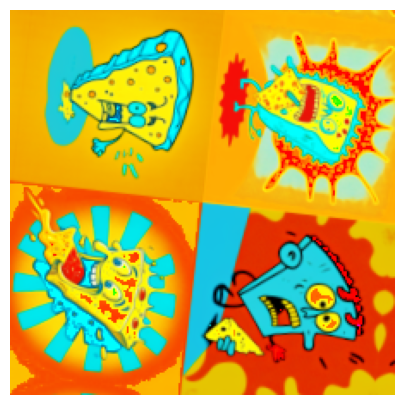

In [ ]:
x, y = loader.train.one_batch()
show_image(x[1])

In [ ]:
def cosine_distance(y_pred, y):
    y_pred = y_pred.cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    return cosine_similarity(y_pred, y).mean()

In [ ]:
resnet = resnet34
resnet.fc = nn.Sequential(
    nn.Linear(512, 512),
    nn.Sigmoid(),
    nn.Linear(512, 512),
    nn.BatchNorm1d(512),
    nn.Sigmoid(),
    nn.Linear(512, 768)
)

# Первые две эпохи lr сохраняется = lr_max, затем убывает до lr_max/div_final
pct_start = 0.5
lr_max = 5e-2
div = 1
div_final = 1e3
sched = {'lr': combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final)}

scheduler = ParamScheduler(sched)
learn = vision_learner(loader, resnet, metrics = cosine_distance)
learn.fine_tune(NUM_EPOCHS, base_lr = LEARNING_RATE, wd = WEIGHT_DECAY, cbs = scheduler)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,cosine_distance,time
0,3.210225,0.073740,0.889010,04:15


epoch,train_loss,valid_loss,cosine_distance,time
0,0.308762,0.041228,0.944004,06:21
1,0.089308,0.033794,0.952908,06:13
2,0.057375,0.030966,0.955722,06:09
3,0.036249,0.023557,0.963455,06:02


In [ ]:
vit = create_model('vit_base_patch16_224', pretrained = True)
for param in vit.parameters():
    param.requires_grad = False

vit.head = nn.Sequential(
    nn.Linear(768, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 768)
)

learn_v = Learner(loader, vit, metrics = cosine_distance)
learn_v.fine_tune(NUM_EPOCHS, base_lr = LEARNING_RATE, wd = WEIGHT_DECAY)

epoch,train_loss,valid_loss,cosine_distance,time
0,0.072383,0.066895,0.940191,00:35


epoch,train_loss,valid_loss,cosine_distance,time
0,0.035039,0.039780,0.954013,00:35
1,0.030932,0.035294,0.957812,00:36
2,0.027071,0.029359,0.960693,00:35
3,0.024234,0.028797,0.961194,00:35


In [ ]:
swin = create_model('swin_base_patch4_window7_224', pretrained = True)
for param in swin.parameters():
    param.requires_grad = False

swin.head = nn.Sequential(
    nn.Linear(swin.head.in_features, 768),
    nn.Sigmoid(),
    nn.Linear(768, 768),
    nn.AdaptiveAvgPool3d((1, 1, 768)),
    nn.Flatten(),
)

learn_s = Learner(loader, swin, metrics = cosine_distance)
learn_s.fine_tune(NUM_EPOCHS, wd = WEIGHT_DECAY, base_lr = LEARNING_RATE)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch,train_loss,valid_loss,cosine_distance,time
0,0.049637,0.034647,0.947799,00:36


epoch,train_loss,valid_loss,cosine_distance,time
0,0.026811,0.031041,0.951105,00:39
1,0.025368,0.027054,0.955896,00:38
2,0.022328,0.024917,0.957677,00:36
3,0.018631,0.023758,0.958966,00:36


In [ ]:
deit = create_model('deit_base_patch16_224', pretrained = True)
for param in deit.parameters():
    param.requires_grad = False

deit.head = nn.Sequential(
    nn.Linear(768, 256),
    nn.BatchNorm1d(256),
    nn.Sigmoid(),
    nn.Linear(256, 512),
    nn.BatchNorm1d(512),
    nn.Sigmoid(),
    nn.Linear(512, 768)
)

pct_start = 0.5
lr_max = 5e-2
div = 1
div_final = 1e3
sched = {'lr': combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final)}

scheduler = ParamScheduler(sched)
learn_d = Learner(loader, deit, metrics = cosine_distance)
learn_d.fine_tune(NUM_EPOCHS, base_lr = LEARNING_RATE, wd = WEIGHT_DECAY, cbs = scheduler)

epoch,train_loss,valid_loss,cosine_distance,time
0,3.556437,0.026736,0.959165,00:39


epoch,train_loss,valid_loss,cosine_distance,time
0,0.636601,0.028822,0.956046,00:36
1,0.120073,0.029869,0.954187,00:40
2,0.043133,0.028852,0.955667,00:35
3,0.026933,0.025128,0.961464,00:35


In [ ]:
beit = create_model('beit_base_patch16_224', pretrained = True)
for param in beit.parameters():
    param.requires_grad = False

beit.head = nn.Sequential(
    nn.Linear(768, 256),
    nn.BatchNorm1d(256),
    nn.Sigmoid(),
    nn.Linear(256, 256),
    nn.BatchNorm1d(256),
    nn.Sigmoid(),
    nn.Linear(256, 768)
)

pct_start = 0.5
lr_max = 5e-2
div = 1
div_final = 1e3
sched = {'lr': combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final)}

scheduler = ParamScheduler(sched)
learn_b = Learner(loader, beit, metrics = cosine_distance)
learn_b.fine_tune(NUM_EPOCHS + 1, base_lr = LEARNING_RATE, wd = WEIGHT_DECAY, cbs = scheduler)

epoch,train_loss,valid_loss,cosine_distance,time
0,0.869150,0.026179,0.960189,00:40


epoch,train_loss,valid_loss,cosine_distance,time
0,0.182437,0.026365,0.959839,00:37
1,0.049653,0.028490,0.956484,00:39
2,0.030377,0.029537,0.954809,00:36
3,0.026502,0.026865,0.958935,00:37
4,0.023793,0.024876,0.962049,00:43


In [ ]:
densenet = create_model('densenet121', pretrained = True)
for param in densenet.parameters():
    param.requires_grad = False

densenet.classifier = nn.Sequential(
    nn.Linear(1024, 256),
    nn.BatchNorm1d(256),
    nn.Sigmoid(),
    nn.Linear(256, 512),
    nn.BatchNorm1d(512),
    nn.Sigmoid(),
    nn.Dropout(p = 0.3),
    nn.Linear(512, 768)
)

pct_start = 0.5
lr_max = 5e-2
div = 1
div_final = 1e3
sched = {'lr': combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final)}

scheduler = ParamScheduler(sched)
learn_c = Learner(loader, densenet, metrics = cosine_distance)
learn_c.fine_tune(NUM_EPOCHS, base_lr = LEARNING_RATE, wd = WEIGHT_DECAY, cbs = scheduler)

epoch,train_loss,valid_loss,cosine_distance,time
0,3.163900,0.033423,0.949277,00:44


epoch,train_loss,valid_loss,cosine_distance,time
0,0.641919,0.057868,0.910097,00:36
1,0.159345,0.035962,0.944425,00:39
2,0.070142,0.032188,0.950458,00:42
3,0.043239,0.025330,0.961125,00:38


In [ ]:
import timm
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [ ]:
def make_predict(learner):
  predicts = []
  for img in os.listdir('Ph/images_test'):
    test_img = PILImage.create("Ph/images_test/" + img)
    predicts.append(learner.predict(test_img)[2])
  print(len(predicts), len(predicts[0]))
  print(predicts[0])
  return predicts

In [ ]:
predict_resnet = make_predict(learn)

In [ ]:
predict_vit = make_predict(learn_v)

In [ ]:
predict_deit = make_predict(learn_d)

In [ ]:
predict_beit = make_predict(learn_b)

In [ ]:
predict_densenet = make_predict(learn_c)

In [ ]:
test_target = [prompts['emb'][i] for i in range(0, len(prompts), 20)]

Усреднение предиктов моделей

In [ ]:
result = (np.array(predict_vit) + np.array(predict_beit) + np.array(predict_deit) + np.array(predict_densenet)) / 4

In [ ]:
cos = 0
for i in range(36):
  cos += cosine_similarity(result[i].view(1, -1), test_target[i].view(1, -1))
print(cos / 36)

[[0.9655191]]
